In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [2]:
hffm = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/061522/hffm_061522.pickle')

In [3]:
[x for x in hffm.columns.values if 'saccTimes' in x]

['FmLt_gazeshift_left_saccTimes_dHead',
 'FmLt_gazeshift_right_saccTimes_dHead',
 'FmLt_comp_left_saccTimes_dHead',
 'FmLt_comp_right_saccTimes_dHead',
 'FmLt_gazeshift_left_saccTimes_dHead1',
 'FmLt_gazeshift_right_saccTimes_dHead1',
 'FmLt_comp_left_saccTimes_dHead1',
 'FmLt_comp_right_saccTimes_dHead1']

In [4]:
sacc = hffm.loc[36, 'FmLt_gazeshift_left_saccTimes_dHead'].copy()

In [7]:
eyeT = hffm.loc[36, 'FmLt_eyeT'].copy()
theta = hffm.loc[36, 'FmLt_theta'].copy()

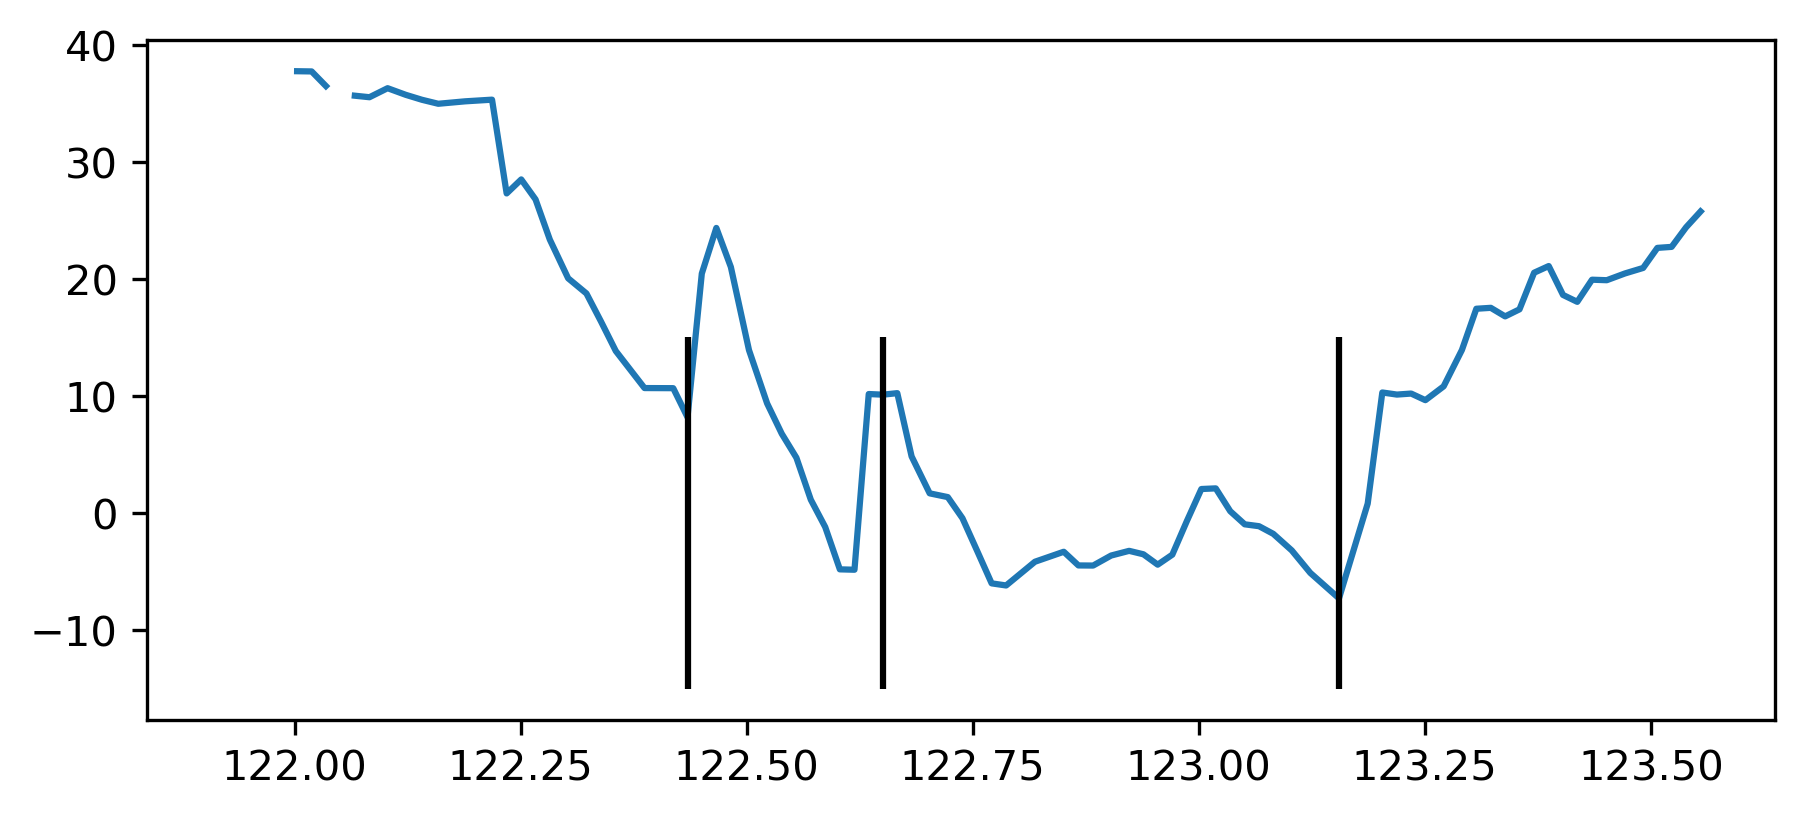

In [65]:
def keep_first_saccade(eventT, win=0.020):
    duplicates = set([])
    for t in eventT:
        new = eventT[((eventT-t)<win) & ((eventT-t)>0)]
        duplicates.update(list(new))
    out = np.sort(np.setdiff1d(eventT, np.array(list(duplicates)), assume_unique=True))
    return out

i0 = 6510; i1 = 6600
t0 = eyeT[i0]; t1 = eyeT[i1]

sacc_in_range = sacc[(sacc>t0) * (sacc<t1)].copy()

plt.figure(figsize=(7,3),dpi=300)
plt.plot(eyeT[i0:i1], theta[i0:i1])
plt.vlines(keep_first_saccade(sacc_in_range), -15, 15, 'k')

In [41]:
eventT = sacc_in_range.astype(float).copy()
print(eventT)

duplicates = set([])
for t in eventT:
    new = eventT[((t-eventT)<0.020) & ((t-eventT)>0)]
    duplicates.update(list(new))
out = np.sort(np.setdiff1d(eventT, np.array(list(duplicates)), assume_unique=True))

print(out)

[122.434605 122.450407 122.466471 122.650803 123.155136]
[122.466471 122.650803 123.155136]


In [42]:
psth_bins = np.arange(-1,1.001,1/1000)

In [43]:
def calc_PSTH(spikeT, eventT, bandwidth=10, resample_size=1, edgedrop=15, win=1000):
    """
    bandwidth (in msec)
    resample_size (msec)
    edgedrop (msec to drop at the start and end of the window so eliminate artifacts of filtering)
    win = 1000msec before and after
    """
    # some conversions
    bandwidth = bandwidth/1000 # msec to sec
    resample_size = resample_size/1000 # msec to sec
    win = win/1000 # msec to sec
    edgedrop = edgedrop/1000
    edgedrop_ind = int(edgedrop/resample_size)

    # setup time bins
    bins = np.arange(-win-edgedrop, win+edgedrop+resample_size, resample_size)

    # get timestamp of spikes relative to events in eventT
    sps = []
    for i, t in enumerate(eventT):
        sp = spikeT-t
        sp = sp[(sp <= (win+edgedrop)) & (sp >= (-win-edgedrop))] # only keep spikes in this window
        sps.extend(sp)
    sps = np.array(sps) # all values in here are between -1 and 1

    # kernel density estimation
    kernel = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sps[:,np.newaxis])
    density = kernel.score_samples(bins[:,np.newaxis])
    sdf = np.exp(density)*(np.size(sps)/np.size(eventT)) # convert back to spike rate
    sdf = sdf[edgedrop_ind:-edgedrop_ind]

    return sdf

def keep_arrival_saccades(eventT, win=0.020):
    duplicates = set([])
    for t in eventT:
        new = eventT[((t-eventT)<win) & ((t-eventT)>0)]
        duplicates.update(list(new))
    out = np.sort(np.setdiff1d(eventT, np.array(list(duplicates)), assume_unique=True))
    return out

In [44]:
from tqdm import tqdm

In [67]:
right_sacc = {}
left_sacc = {}
n2 = {}

for x, ind in enumerate([39,112,126]):
    print(x)
    spikeT = hffm.loc[ind, 'FmLt_spikeT'].copy()
    right_eventT = keep_arrival_saccades(hffm.loc[ind, 'FmLt_gazeshift_right_saccTimes_dHead'].copy())
    left_eventT = keep_arrival_saccades(hffm.loc[ind, 'FmLt_gazeshift_left_saccTimes_dHead'].copy())
    
    n2[x] = len(right_eventT) + len(left_eventT)
    left_sacc[x] = calc_PSTH(spikeT, left_eventT)
    right_sacc[x] = calc_PSTH(spikeT, right_eventT)

0
1
2


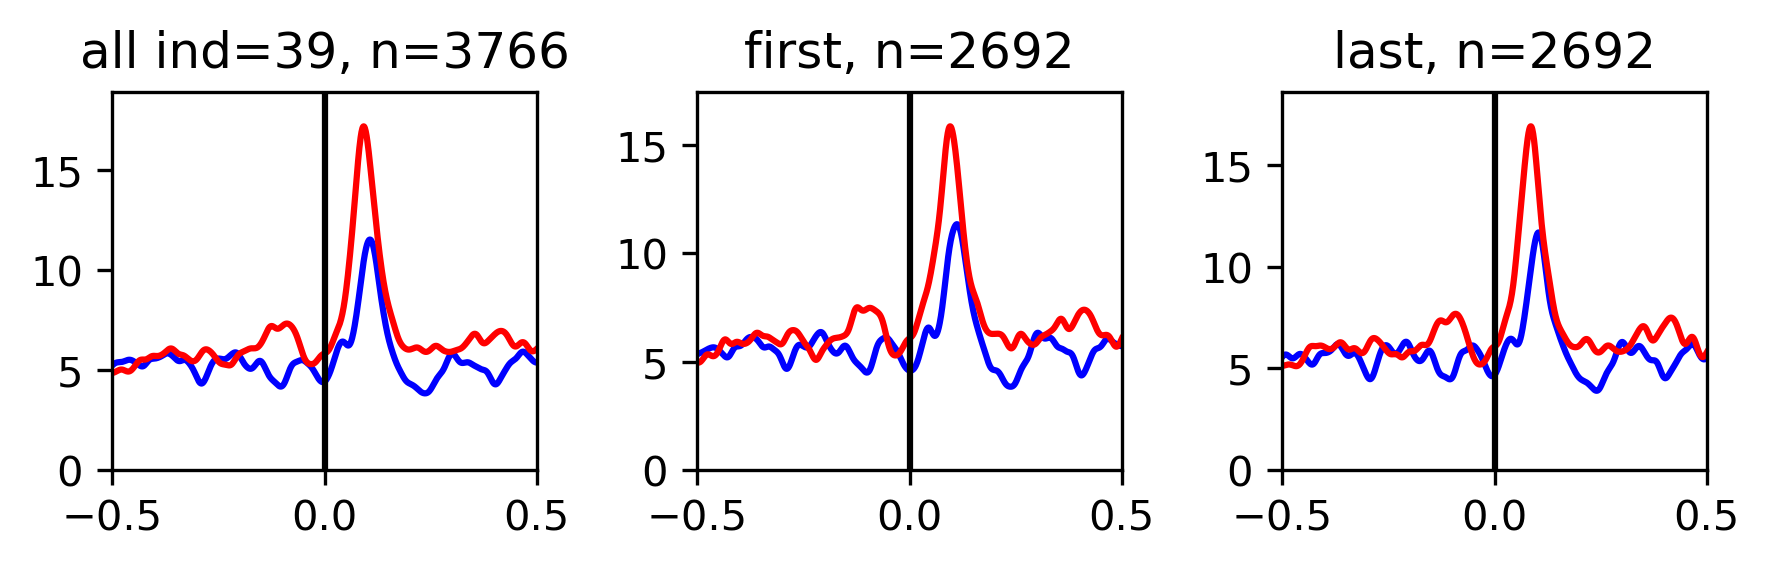

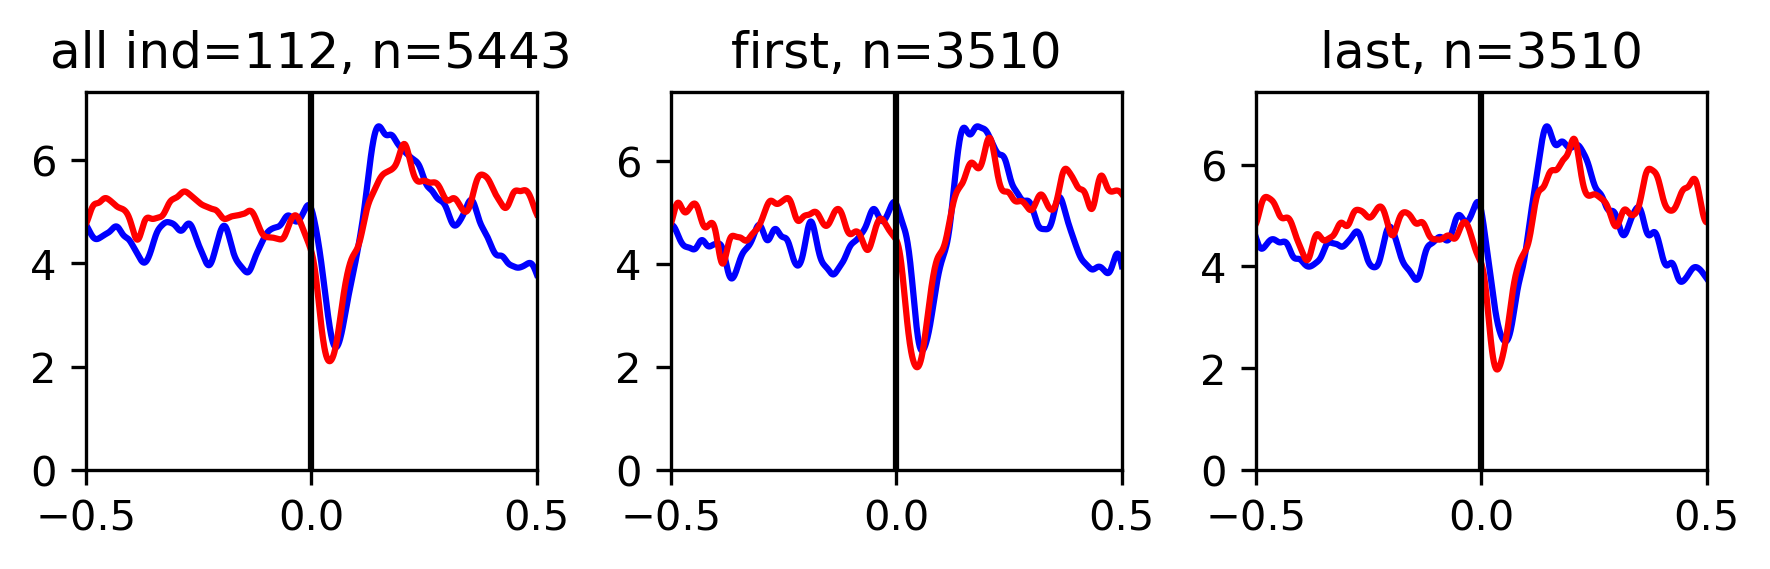

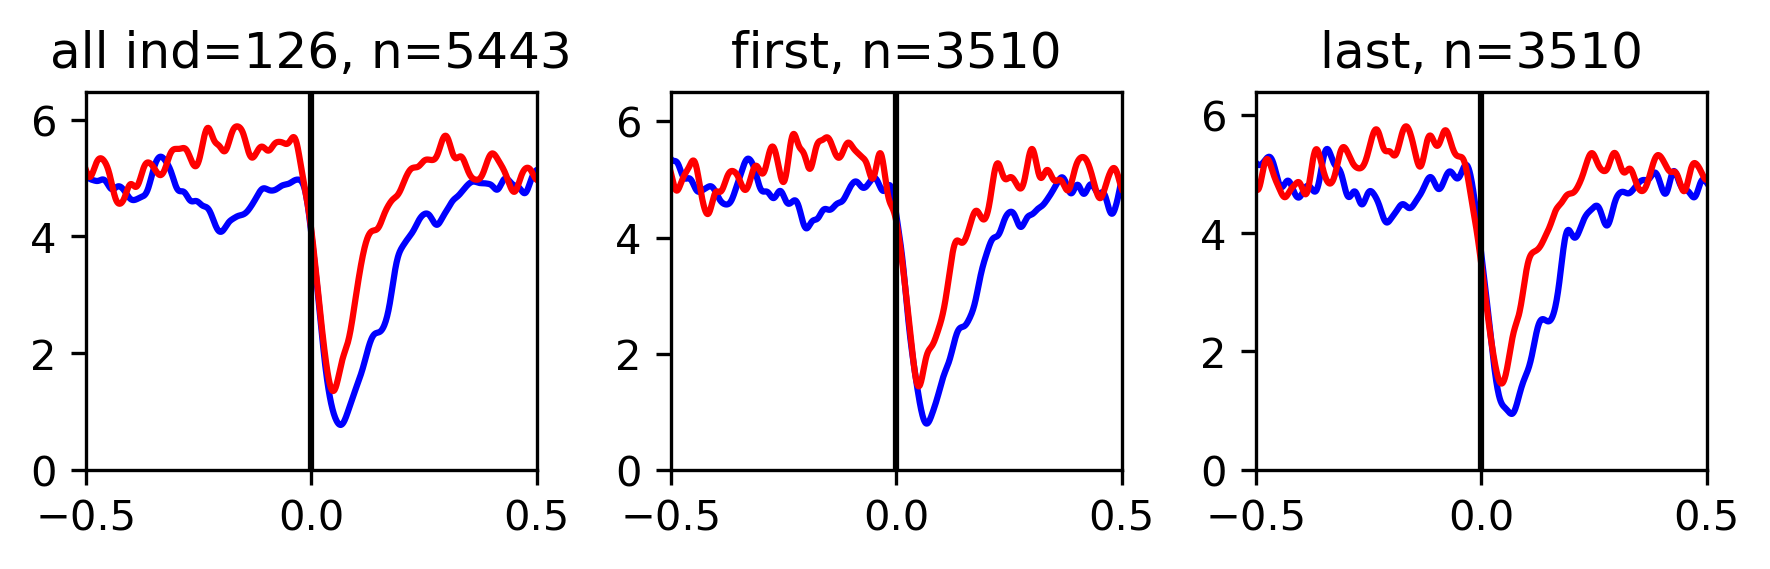

In [68]:
for x, ind in enumerate([39,112,126]):
    fig, [ax0, ax1, ax2] = plt.subplots(1,3,figsize=(6,2),dpi=300)
    
    ax0.plot(psth_bins, hffm.loc[ind, 'FmLt_gazeshift_left_saccPSTH_dHead'], 'b')
    ax0.plot(psth_bins, hffm.loc[ind, 'FmLt_gazeshift_right_saccPSTH_dHead'], 'r')
    max0 = np.max([hffm.loc[ind, 'FmLt_gazeshift_left_saccPSTH_dHead'], hffm.loc[ind, 'FmLt_gazeshift_right_saccPSTH_dHead']])*1.1
    ax0.vlines(0, 0, max0, 'k'); ax0.set_ylim([0, max0])
    n0 = len(hffm.loc[ind, 'FmLt_gazeshift_left_saccTimes_dHead']) + len(hffm.loc[ind, 'FmLt_gazeshift_right_saccTimes_dHead'])
    
    ax1.plot(psth_bins, hffm.loc[ind, 'FmLt_gazeshift_left_saccPSTH_dHead1'], 'b')
    ax1.plot(psth_bins, hffm.loc[ind, 'FmLt_gazeshift_right_saccPSTH_dHead1'], 'r')
    max1 = np.max([hffm.loc[ind, 'FmLt_gazeshift_left_saccPSTH_dHead1'], hffm.loc[ind, 'FmLt_gazeshift_right_saccPSTH_dHead1']])*1.1
    ax1.vlines(0, 0, max1, 'k'); ax1.set_ylim([0, max1])
    n1 = len(hffm.loc[ind, 'FmLt_gazeshift_left_saccTimes_dHead1']) + len(hffm.loc[ind, 'FmLt_gazeshift_right_saccTimes_dHead1'])
    
    ax2.plot(psth_bins, left_sacc[x], 'b')
    ax2.plot(psth_bins, right_sacc[x], 'r')
    max2 = np.max([left_sacc[x], right_sacc[x]])*1.1
    ax2.vlines(0, 0, max2, 'k'); ax2.set_ylim([0, max2])
    
    for i, ax in enumerate([ax0, ax1, ax2]):
        ax.set_title(['all ind={}, n={}'.format(ind, n0),'first, n={}'.format(n1),'last, n={}'.format(n2[x])][i])
        ax.set_xlim([-0.5,0.5])
        
    fig.tight_layout()